# Environment

In [ ]:
!pip install bertviz
!pip install datasets evaluate

import time
import enum
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from bertviz import head_view
from datasets import load_dataset
from sklearn.feature_selection import chi2
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,  auc, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, BertModel

# Data

## Import Dataset

In [ ]:
train_dataset = load_dataset('ag_news', split='train')
test_dataset = load_dataset('ag_news', split='test')

## Visualize Data

In [ ]:
# View a single example
print(train_dataset[0])

# Get column names
print(train_dataset.column_names)

# Check label names
label_names = train_dataset.features['label'].names
print(label_names)

# Count class distribution
from collections import Counter

label_counts = Counter(example['label'] for example in train_dataset)
for idx, count in label_counts.items():
    print(f"{label_names[idx]}: {count}")

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
['text', 'label']
['World', 'Sports', 'Business', 'Sci/Tech']
Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


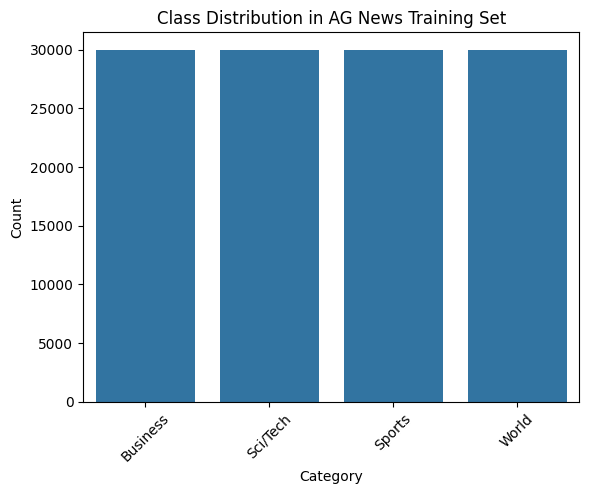

In [ ]:
# Convert to pandas DataFrame for easier analysis
df_train = pd.DataFrame(train_dataset)

# Map label indices to names
df_train['label_name'] = df_train['label'].apply(lambda x: label_names[x])

# Plot distribution
sns.countplot(data=df_train, x='label_name')
plt.title("Class Distribution in AG News Training Set")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

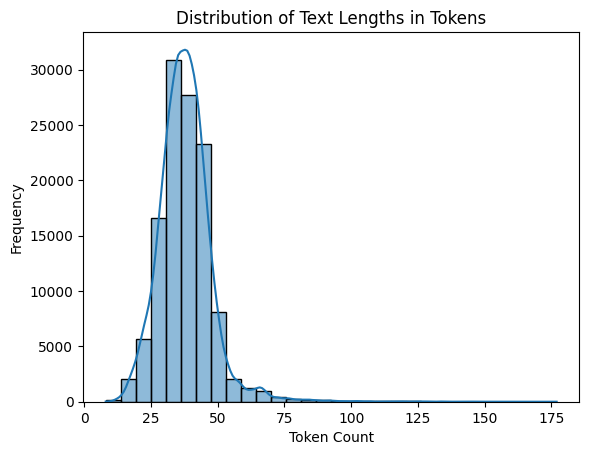

In [ ]:
df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split()))

sns.histplot(df_train['text_len'], bins=30, kde=True)
plt.title("Distribution of Text Lengths in Tokens")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()


# BERT

In [ ]:
# load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

# Experiments

## Experiment 1

Random Forest Accuracy: 0.8010
Random Forest Accuracy: 0.8550
RNN Accuracy: 0.7900
  Embedding  Best K  KNN Accuracy  LogReg Accuracy  Random Forest Accuracy  \
0       CLS       7         0.814            0.845                   0.801   
1      Mean       9         0.868            0.866                   0.855   

                                        RNN Accuracy  
0                                               0.79  
1                precision    recall  f1-score   ...  


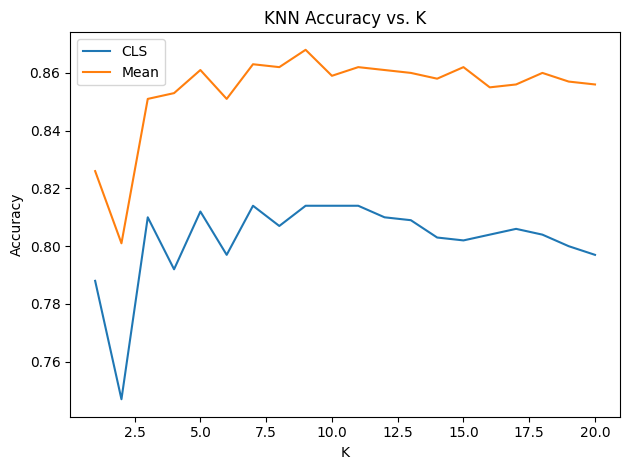

In [ ]:
train_texts = train_dataset['text'][:4000]
train_labels = train_dataset['label'][:4000]
test_texts = test_dataset['text'][:1000]
test_labels = test_dataset['label'][:1000]

def get_embeddings(texts, mode='cls', batch_size=16):
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=64)
        tokens = {key: val.to(model.device) for key, val in tokens.items()}
        with torch.no_grad():
            output = model(**tokens).last_hidden_state

        if mode == 'cls':
            emb = output[:, 0, :]
        elif mode == 'mean':
            mask = tokens['attention_mask'].unsqueeze(-1).expand_as(output)
            emb = (output * mask).sum(1) / mask.sum(1)
        elif mode == 'last':
            emb = output[:, -1, :]
        vecs.extend(emb.cpu().numpy())
    return vecs

train_cls = get_embeddings(train_texts, mode='cls')
test_cls = get_embeddings(test_texts, mode='cls')
train_mean = get_embeddings(train_texts, mode='mean')
test_mean = get_embeddings(test_texts, mode='mean')

def encode_texts(texts, tokenizer, max_len=64):
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
    return tokens['input_ids']

X_train_ids = encode_texts(train_texts, tokenizer)
X_test_ids = encode_texts(test_texts, tokenizer)
y_train_tensor = torch.tensor(train_labels)
y_test_tensor = torch.tensor(test_labels)

def knn(X_train, y_train, X_test, y_test):
    best_k = 1
    best_score = 0
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        if acc > best_score:
            best_score = acc
            best_k = k
    return best_k, best_score

def log(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    return acc, report

def random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Random Forest Accuracy: {acc:.4f}")
    report = classification_report(y_test, preds)
    return acc, report

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

train_dataset = TextDataset(X_train_ids, y_train_tensor)
test_dataset = TextDataset(X_test_ids, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

def rnn(train_loader, test_loader, vocab_size, num_classes=4, epochs=10, emb_dim=256, hidden_dim=256, dropout_rate=0.3):
    class VanillaRNN(nn.Module):
        def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes):
            super().__init__()
            self.embedding = nn.Embedding(vocab_size, emb_dim)
            self.dropout = nn.Dropout(dropout_rate)
            self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout_rate, num_layers=2)
            self.layer_norm = nn.LayerNorm(hidden_dim * 2)
            self.attention = nn.Linear(hidden_dim * 2, 1)
            self.fc = nn.Linear(hidden_dim * 2, num_classes)

        def forward(self, x):
            embedded = self.embedding(x)
            embedded = self.dropout(embedded)

            rnn_out, _ = self.rnn(embedded)
            rnn_out = self.layer_norm(rnn_out)

            # Attention mechanism
            attn_weights = self.attention(rnn_out)
            attn_weights = F.softmax(attn_weights, dim=1)

            # Weighted sum of hidden states
            context = torch.sum(attn_weights * rnn_out, dim=1)

            context = self.dropout(context)
            output = self.fc(context)

            return output

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VanillaRNN(vocab_size, emb_dim, hidden_dim, num_classes).to(device)
    optimizer =torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # Evaluation
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            pred_labels = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    report = classification_report(true, preds)
    print(f"RNN Accuracy: {acc:.4f}")
    return acc, report

k_cls, acc_knn_cls = knn(train_cls, train_labels, test_cls, test_labels)
acc_log_cls, report_cls = log(train_cls, train_labels, test_cls, test_labels)
acc_rf_cls, report_rf_cls = random_forest(train_cls, train_labels, test_cls, test_labels)

k_mean, acc_knn_mean = knn(train_mean, train_labels, test_mean, test_labels)
acc_log_mean, report_mean = log(train_mean, train_labels, test_mean, test_labels)
acc_rf_mean, report_rf_mean = random_forest(train_mean, train_labels, test_mean, test_labels)

acc_rnn, report_rnn = rnn(train_loader, test_loader, vocab_size=tokenizer.vocab_size)

summary = pd.DataFrame({
    "Embedding": ["CLS", "Mean"],
    "Best K": [k_cls, k_mean],
    "KNN Accuracy": [acc_knn_cls, acc_knn_mean],
    "LogReg Accuracy": [acc_log_cls, acc_log_mean],
    "Random Forest Accuracy": [acc_rf_cls, acc_rf_mean],
    "RNN Accuracy": [acc_rnn, report_rnn]
})
print(summary)

def plot_knn_curve(X_train, y_train, X_test, y_test):
    ks = list(range(1, 21))
    accs = []
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        accs.append(knn.score(X_test, y_test))
    return ks, accs

ks1, accs1 = plot_knn_curve(train_cls, train_labels, test_cls, test_labels)
ks2, accs2 = plot_knn_curve(train_mean, train_labels, test_mean, test_labels)

plt.plot(ks1, accs1, label="CLS")
plt.plot(ks2, accs2, label="Mean")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. K")
plt.legend()
plt.tight_layout()
plt.show()

## Experiment 2

In [ ]:
#Overall does not take too long so feel free to play around with it.
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=4)

def tokenize(ex):
    return tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

small_train_data = train_dataset.shuffle(seed=1).select(range(10000))
small_eval_data = test_dataset.select(range(1000))

accuracy = evaluate.load("accuracy")

def compute_metrics(eval):
    logits, labels = eval
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./output",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./log",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    report_to="none", # Keep this cause it started asking for api keys
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_data,
    eval_dataset=small_eval_data,
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate(test_dataset)
print("Final test accuracy:", results["eval_accuracy"])



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

## Experiment 3


In [ ]:
best_probing_acc = acc_log_cls

fine_tuned_acc = results["eval_accuracy"]

labels = [
    'KNN (Mean)',
    'LogReg (Mean)',
    'Random Forest (Mean)',
    'Vanilla RNN',
    'Fine-tuned BERT'
]

accuracies = [
    acc_knn_mean,
    acc_log_mean,
    acc_rf_mean,
    acc_rnn,
    fine_tuned_acc
]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=['gray', 'blue', 'green', 'purple', 'orange'])
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison on AG News")

# Add accuracy labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom')

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Experiment 4



In [ ]:
pred_output = trainer.predict(test_dataset)
logits = pred_output.predictions
labels = pred_output.label_ids
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)
preds = np.argmax(logits, axis=1)

results = {"correct": {}, "incorrect": {}}

for cls in range(4):
    for i in range(len(preds)):
        pred = preds[i]
        label = labels[i]
        if pred == cls and label == cls and cls not in results["correct"]:
            results["correct"][cls] = i
        elif pred == cls and label != cls and cls not in results["incorrect"]:
            results["incorrect"][cls] = i
    if len(results["correct"]) == 4 and len(results["incorrect"]) == 4:
        break
test_raw = load_dataset('ag_news', split='test')
def show_attention(index, layer=10, head=0):
    text = test_raw[index]["text"]
    print(f"\n Text (Index {index}):\n{text[:200]}...\n")

    encoded = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    encoded = {k: v.to(model.device) for k, v in encoded.items()}

    with torch.no_grad():
        output = model.bert(**encoded, output_attentions=True)

    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    head_view(output.attentions, tokens)


for cls in range(4):
    print(f"\n Correct Prediction — Class {cls}")
    show_attention(results["correct"][cls])

    print(f"\n Incorrect Prediction — Class {cls}")
    show_attention(results["incorrect"][cls])